In [30]:
"""
Step 1. Load data
"""
from utils.trial import load_trial

# Edit these values
SUBJECTS_DIR = "subjects"
SUBJECT_NAME = "ncbc_s10"
TRIAL_NAME = "TM_p6"
RESULTS_FILE = "results.json"
# ================================

trial = load_trial(SUBJECTS_DIR, SUBJECT_NAME, TRIAL_NAME)
SUBJECT_WEIGHT = trial.subject_weight

sensors = trial.load_sensors()
treadmill_unaligned = trial.load_treadmill()

In [32]:
"""
Step 2. Use the alignment tool to find signal offsets.
Only uncomment one side at a time.
"""
from utils.viz import visually_align_signal

# Uncomment below to align left ankle and left force signals
#SENSOR_SIGNAL = sensors.left_df['accel_filtered']
#TREADMILL_SIGNAL = treadmill_unaligned.left_df['vgrf']

# Uncomment below to align right ankle and right force signals
SENSOR_SIGNAL = sensors.right_df['accel_filtered']
TREADMILL_SIGNAL = treadmill_unaligned.right_df['vgrf'] 

visually_align_signal(SENSOR_SIGNAL, TREADMILL_SIGNAL)
#sensors.left_df.head()

In [69]:
"""
Step 3. Align sensor and treadmill signals.

Use the above cell to visually determine offsets for the treadmill signals.
After you do that, update the values of LEFT_VGRF_OFFSET and RIGHT_VGRF_OFFSET.
"""

import pandas as pd
from utils.treadmill import TreadmillData

LEFT_VGRF_OFFSET = 801     # INPUT VALUE FROM STEP 2!
RIGHT_VGRF_OFFSET = 648     # INPUT VALUE FROM STEP 2!

def apply_offset(treadmill_df: pd.DataFrame, offset: int):
    """
    Applies an offset to treadmill_df
    """
    if offset < 0:
        out_df = treadmill_df.iloc[-offset:]
    elif offset > 0:
        padding = pd.DataFrame({'time': [0]*offset, 'vgrf': [0]*offset})
        out_df = pd.concat([padding, treadmill_df])
    else:
        out_df = treadmill_df
    return out_df.reset_index(drop=True)

left_df = apply_offset(treadmill_unaligned.left_df, LEFT_VGRF_OFFSET)
right_df = apply_offset(treadmill_unaligned.right_df, RIGHT_VGRF_OFFSET)

treadmill = TreadmillData(left_df, right_df)

[1113    0.967404
1114    0.984718
1115    1.003156
1116    1.010154
1117    0.993086
          ...   
2071    0.972254
2072    0.978320
2073    0.986356
2074    0.995395
2075    1.003884
Name: accel_filtered, Length: 963, dtype: float64, 2076    1.010199
2077    1.013148
2078    1.012301
2079    1.008055
2080    1.001439
          ...   
2183    1.058462
2184    1.041242
2185    1.020307
2186    0.998710
2187    0.978935
Name: accel_filtered, Length: 112, dtype: float64, 2188    0.962319
2189    0.948981
2190    0.938186
2191    0.928922
2192    0.920427
          ...   
2291    0.924865
2292    0.938940
2293    0.949817
2294    0.953458
2295    0.948287
Name: accel_filtered, Length: 108, dtype: float64, 2296    0.935525
2297    0.918792
2298    0.903064
2299    0.893247
2300    0.892739
          ...   
2385    1.069493
2386    1.030681
2387    0.983735
2388    0.937049
2389    0.898563
Name: accel_filtered, Length: 94, dtype: float64, 2390    0.873780
2391    0.864422
2392    0.8681

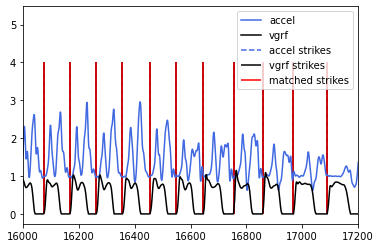

In [76]:
"""
Step 3. Extract strike indices and stances from the left.
"""
import matplotlib.pyplot as plt
from operator import itemgetter
from utils.stance import parse_and_match_stances
from utils.config import PipelineConfig

# You can uncomment and change the config to see how it affects the results.
#  See all parameters in utils/config.py

config = PipelineConfig(
    accel_peak_params={
        'height': 1.0,
        'prominence': 0.5,
        'width': 5.0,
        'distance': 10
    },
    jerk_peak_params={
        'height': 0.0,
        'prominence': 0.1
    },
    jerk_window_size=50,
    stance_matching_time_threshold=5,
    accel_filters=[],
    vgrf_filters=[],
    min_stance_size=80,
    max_stance_size=140
)

left_strikes, left_stances, debug = parse_and_match_stances(
    sensors.left_df['accel_filtered'],
    sensors.left_df['accel'],
    sensors.waist_df['accel_filtered'],
    treadmill.left_df['vgrf'],
    config # <--- Uncomment to use your own config
)

# Plot accel
plt.plot(sensors.left_df['accel_filtered'], color='royalblue',label='accel')
plt.vlines(debug['accel_strikes'], 0, 4, color='royalblue', linestyle='--', label='accel strikes')

# Plot vgrf
plt.plot(treadmill.left_df['vgrf'], color='black', label='vgrf')
plt.vlines(debug['vgrf_strikes'], 0, 4, color='black', label='vgrf strikes')

# Plot matched strikes
plt.vlines(list(map(itemgetter(0), left_strikes)), 0, 4, color='red', label='matched strikes')

# show plot
#plt.xlim(3000,4000)
plt.xlim(16000,17200)
#plt.xlim(4000,5000)
plt.legend()
plt.show()




# NOTE: Dropping filters and increasing stance_matching_time_threshold from 5 -> 10
# will cause more strikes to be matched.

[1038    0.930338
1039    0.961089
1040    1.043869
1041    1.186261
1042    1.376891
          ...   
2140    0.930884
2141    0.928091
2142    0.925710
2143    0.924559
2144    0.925383
Name: accel_filtered, Length: 1107, dtype: float64, 2145    0.928423
2146    0.933206
2147    0.938656
2148    0.943470
2149    0.946515
          ...   
2238    0.903074
2239    0.910782
2240    0.915613
2241    0.915370
2242    0.910192
Name: accel_filtered, Length: 98, dtype: float64, 2243    0.902500
2244    0.896197
2245    0.895304
2246    0.902467
2247    0.917902
          ...   
2356    0.940245
2357    0.960124
2358    0.968983
2359    0.965428
2360    0.951151
Name: accel_filtered, Length: 118, dtype: float64, 2361    0.930902
2362    0.911998
2363    0.903353
2364    0.913888
2365    0.950355
          ...   
2457    0.875898
2458    0.894652
2459    0.908935
2460    0.918162
2461    0.923666
Name: accel_filtered, Length: 101, dtype: float64, 2462    0.928693
2463    0.938065
2464    0.957

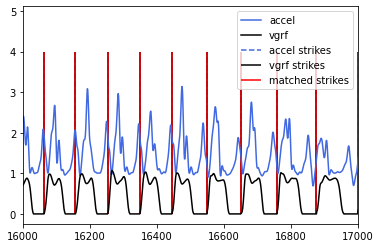

In [35]:
"""
Step 4. Extract strike indices and stances from the right.
"""

import matplotlib.pyplot as plt
from operator import itemgetter
from utils.stance import parse_and_match_stances
from utils.config import PipelineConfig

# You can uncomment and change the config to see how it affects the results.
#  See all parameters in utils/config.py

config = PipelineConfig(
    accel_peak_params={
        'height': 1.0,
        'prominence': 0.5,
        'width': 5.0,
        'distance': 10
    },
    jerk_peak_params={
        'height': 0.0,
        'prominence': 0.1
    },
    jerk_window_size=50,
    stance_matching_time_threshold=10,
    accel_filters=[],
    vgrf_filters=[],
    min_stance_size=80,
    max_stance_size=140
)


right_strikes, right_stances, debug = parse_and_match_stances(
    sensors.right_df['accel_filtered'],
    sensors.right_df['accel'],
    sensors.waist_df['accel_filtered'],
    treadmill.right_df['vgrf'],
    config # <--- Uncomment to use your own config
)

# Plot accel
plt.plot(sensors.right_df['accel_filtered'], color='royalblue',label='accel')
plt.vlines(debug['accel_strikes'], 0, 4, color='royalblue', linestyle='--', label='accel strikes')

# Plot vgrf
plt.plot(treadmill.right_df['vgrf'], color='black', label='vgrf')
plt.vlines(debug['vgrf_strikes'], 0, 4, color='black', label='vgrf strikes')

# Plot matched strikes
plt.vlines(list(map(itemgetter(0), right_strikes)), 0, 4, color='red', label='matched strikes')

# show plot
plt.xlim(16000, 17000)
plt.legend()
plt.show()

# NOTE: This side looks like it has good peak detection, but the strikes between the treadmill and sensors
# are not matching up.

In [36]:
"""
Step 5. Merge both sides and run through the model.
"""
import csv
import os
from utils.predict import predict_stance
from utils.output import make_peak_results, make_stance_results

RESULTS_DIR = 'results/ncbc_s10/TM_p6' # Edit me!

REF_PEAKS_FILE = os.path.join(RESULTS_DIR, 'reference_peaks.xlsx')
PRED_PEAKS_FILE = os.path.join(RESULTS_DIR, 'pred_peaks.xlsx')
REF_STANCES_FILE_LEFT = os.path.join(RESULTS_DIR, 'reference_waveforms_L.xlsx')
REF_STANCES_FILE_RIGHT = os.path.join(RESULTS_DIR, 'reference_waveforms_R.xlsx')
PRED_STANCES_FILE_LEFT = os.path.join(RESULTS_DIR, 'pred_wavevforms_L.xlsx')
PRED_STANCES_FILE_RIGHT = os.path.join(RESULTS_DIR, 'pred_waveforms_R.xlsx')

if os.path.exists(RESULTS_DIR):
    print(f"A directory called {RESULTS_DIR}/ already exists")
else:
    os.makedirs(RESULTS_DIR)

    left_accel_stances = list(map(itemgetter(0), left_stances)) 
    left_vgrf_stances = list(map(itemgetter(1), left_stances))
    right_accel_stances = list(map(itemgetter(0), right_stances))
    right_vgrf_stances = list(map(itemgetter(1), right_stances))

    # Use the MLP model to predict vGRF stances from accel stances
    left_vgrf_pred_stances = list(map(predict_stance, left_accel_stances))
    right_vgrf_pred_stances = list(map(predict_stance, right_accel_stances))

    # Create reference and predicted peak results
    ref_peak_results = make_peak_results(left_vgrf_stances, right_vgrf_stances)
    ref_peak_results.to_excel(REF_PEAKS_FILE, index=False)

    pred_peak_results = make_peak_results(left_vgrf_pred_stances, right_vgrf_pred_stances)
    pred_peak_results.to_excel(PRED_PEAKS_FILE, index=False)

    # Create reference and predicted stance (waveform) results
    left_vgrf_stances = pd.DataFrame(left_vgrf_stances)
    left_vgrf_stances_T = left_vgrf_stances.T
    right_vgrf_stances = pd.DataFrame(right_vgrf_stances)
    right_vgrf_stances_T = right_vgrf_stances.T
    
    left_vgrf_results = pd.DataFrame(left_vgrf_stances_T)
    left_vgrf_results.to_excel(REF_STANCES_FILE_LEFT, index=False)
    right_vgrf_results = pd.DataFrame(right_vgrf_stances_T)
    right_vgrf_results.to_excel(REF_STANCES_FILE_RIGHT, index=False)

    left_vgrf_pred_stances = pd.DataFrame(left_vgrf_pred_stances)
    left_vgrf_pred_stances_T = left_vgrf_pred_stances.T
    right_vgrf_pred_stances = pd.DataFrame(right_vgrf_pred_stances)
    right_vgrf_pred_stances_T = right_vgrf_pred_stances.T
    
    left_pred_waveform_results = pd.DataFrame(left_vgrf_pred_stances_T)
    left_pred_waveform_results.to_excel(PRED_STANCES_FILE_LEFT, index=False)
    right_pred_waveform_results = pd.DataFrame(right_vgrf_pred_stances_T)
    right_pred_waveform_results.to_excel(PRED_STANCES_FILE_RIGHT, index=False)

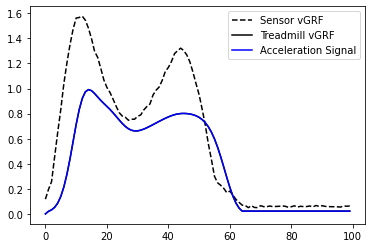

In [37]:
import numpy as np

random_index = np.random.randint(0, len(left_vgrf_pred_stances))

plt.plot(left_vgrf_pred_stances.T[random_index], color = "black", linestyle = "--", label = "Sensor vGRF")
plt.plot(left_vgrf_stances.T[random_index], color = "black",  label = "Treadmill vGRF")
plt.plot(left_accel_stances[random_index], color = "blue",  label = "Acceleration Signal")
plt.legend()
plt.show()


left_bases: [ 1102  1346  2084  2216  2320  2424  2526  2626  2727  2825  2925  3019
  3114  3210  3308  3407  3503  3599  3696  3792  3888  3983  4080  4173
  4267  4358  4453  4547  4640  4732  4830  4923  5018  5110  5205  5298
  5392  5484  5577  5670  5764  5857  5949  6047  6141  6234  6329  6423
  6514  6611  6708  6799  6894  6987  7080  7177  7269  7361  7459  7556
  7653  7747  7842  7940  8037  8134  8230  8326  8424  8519  8620  8715
  8811  8905  9005  9096  9194  9294  9394  9490  9585  9681  9779  9879
  9971 10064 10161 10256 10355 10450 10548 10644 10739 10838 10929 11025
 11124 11221 11319 11415 11513 11610 11702 11801 11896 11994 12090 12191
 12288 12380 12478 12579 12679 12777 12875 12974 13070 13167 13265 13359
 13459 13554 13657 13757 13850 13952 14045 14141 14236 14331 14426 14525
 14623 14721 14817 14914 15009 15109 15204 15301 15398 15498 15596 15690
 15787 15882 15979 16073 16167 16262 16356 16454 16549 16646 16754 16858
 16969 17090 17224 17356 17608]
right_b

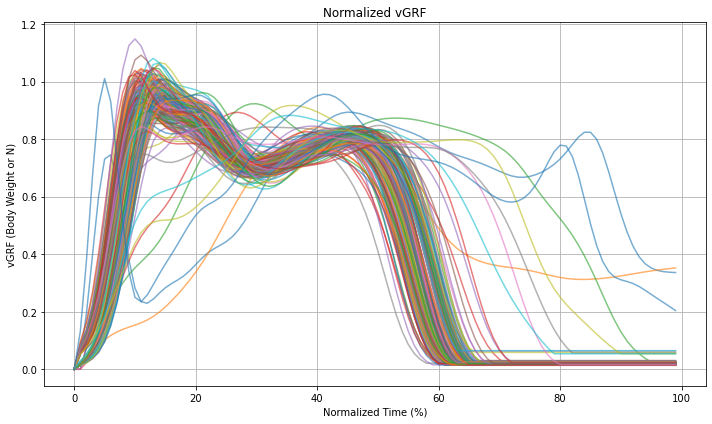

left_bases: [ 1016  1044  1044  1044  2429  1044  2529  2529  1044  1044  2977  3115
  3155  3270  3310  3506  3599  3696  3791  3791  3984  3984  4171  1044
  4359  4359  4507  4543  4543  4792  4922  4922  5109  5109  5298  5298
  5483  5298  5669  5763  5859  5951  5951  6138  6234  6327  1044  6518
  6575  1044  6798  6895  1044  7080  7080  7269  7365  7463  7463  7654
  7752  7463  7944  8038  8038  8233  8038  8388  7463  8619  8715  8811
  8909  8964  9101  9101  9298  9393  9101  9549  9685  9685  9877  9685
 10065  9101 10260 10357 10454 10551 10606 10743 10743 10932 11030 11030
 11030  9101 11419 11513 11513 11706  1044 11898 11996 12037 12092 12092
 12092 12482 12482 12482 12778 12877 12482 12482 13125 13167 13167 13167
 13557 13660 13716 13660 13660 13660 13660 13660 12092 14430 12092 14624
 14624 14624  1044 15012 15113 15210 15304 15399 15399 15597 15597  1044
 15886 15980 15980 15980 16264 16317 15980 16553 16553 16714 16820 16987
 17519]
right_bases: [17519  2115  2224

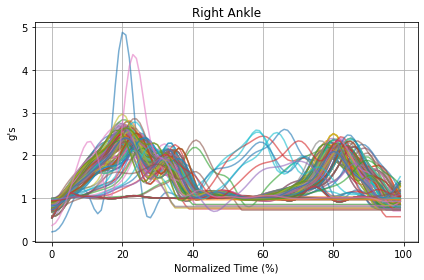

left_bases: [ 1085  2038  2204  2268  2268  2268  2572  2268  2869  2908  3004  2268
  3193  3351  3448  3487  2268  3736  3776  3927  2268  4061  4211  4211
  4397  2268  4547  4679  4679  4867  4962  5055  5055  5055  5055  5428
  5487  5615  5707  5758  5800  5992  5800  6177  6177  6367  6367  6367
  6177  6745  6837  6934  7028  6934  7214  7308  7214  7214  7540  7694
  6934  7889  7889  8079  7889  8274  6177  8465  8465  8659  8659  8815
  8950  9045  9045  9194  9045  9401  9045  9627  9727  6177  6177 10011
 10104 10204 10204 10204 10495  6177 10686 10686 10878 10973 11072 11168
 11168 11360 11458 11555 11555 11688 11360 11939 12037 12135 12234 12327
 12234 12525 12624 12720 12820 12920 12956 12624 13161 13306 12135 13500
 13600 13600 13798 13798 13798 14087 12135 14245 14374 14438 11360 14667
 14764 14858 14957 15006 14957 14957 15345 11360 15541 15541 15541 15794
 15794 15986 15986 15541 16271 15541 16497 16545 16592 16636 16697 16803
 16847 17038 17038 17311 17583]
right_b

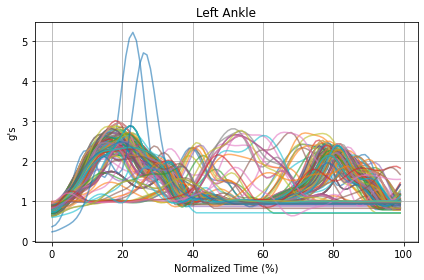

left_bases: [ 1023  1053  1135  1135  1135  3903  1135  5406  6909  1135  7572  7572
  8344  9017  9214  9214  9603  9799  9895  9799 10275 10565 10663  8344
 11337 11385 11337 11670 11818  8344  8344 12402 12402  8344 12794 12990
 12990 13134 13284 13284 13284 13573 13777 14064 14064  1135 14639 14736
 14881 14736 15125 15224 15224 15512 15512 15809 16091 16091 16471 15809
 16722 16775 15809  1135 17558]
right_bases: [ 1053  1135  2940  3036  3903  4280  7379  6909  7379  8344  8250  8344
  9603  9603  9311  9603  9799  9895  9985 10663 10663 10663 11144 12010
 11624 11624 12010 12010 12010 12304 12402 12500 12697 12990 12990 13087
 13284 13284 13379 13476 14064 14064 14064 14351 14542 15224 15224 14929
 14929 15224 15224 15320 15809 15610 15809 16471 16135 16471 16615 16775
 16775 16827 16880 17637 17637]


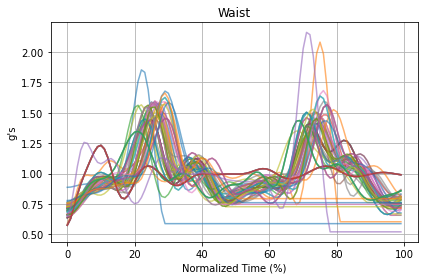

In [38]:
from utils.stance import StanceAnalyzer
import matplotlib.pyplot as plt

analyzer = StanceAnalyzer() 
vgrf = treadmill.left_df['vgrf']  
start_idx, stances = analyzer.extract_treadmill_stances(vgrf)  

#vgrf
plt.figure(figsize=(10, 6))
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Normalized vGRF")
plt.xlabel("Normalized Time (%)")
plt.ylabel("vGRF (Body Weight or N)")
plt.grid(True)
plt.tight_layout()
plt.show()


r_ankle = sensors.right_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(r_ankle)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Right Ankle")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()

l_ankle = sensors.left_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(l_ankle)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Left Ankle")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()

l_waist = sensors.waist_df['accel_filtered']
start_idx, stances = analyzer.extract_treadmill_stances(l_waist)  
for stance in stances:
    plt.plot(stance.values, alpha=0.6)
plt.title("Waist")
plt.xlabel("Normalized Time (%)")
plt.ylabel("g's")
plt.grid(True)
plt.tight_layout()
plt.show()